# Convolutional Neural Networks for Accurate Skin Cancer Diagnosis

Skin cancer is a prevalent type of malignancy in humans, and its diagnosis involves a visual examination and further medical procedures such as dermoscopy, biopsy, and histopathological analysis. However, the classification of skin lesions using automated image analysis is a complex task due to the wide range of variations in the appearance of skin lesions.

Dataset used is the HAM10000 ("Human Against Machine with 10000 training images") dataset.
https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000

It has 7 different classes of skin cancer which are listed below :
1. Melanocytic nevi
2. Melanoma
3. Benign keratosis-like lesions
4. Basal cell carcinoma
5. Actinic keratoses
6. Vascular lesions
7. Dermatofibroma

### Import required moduls/libs for the model

In [38]:
import numpy as np          # linear algebra
import pandas as pd         # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import keras
from keras.models import Sequential, load_model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers.core import Dropout, Activation
from keras.layers import Conv2D, BatchNormalization, MaxPool2D, Flatten, \
     Dense, Input, Activation, Dropout, GlobalAveragePooling2D, AveragePooling2D
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.models import Model
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
import cv2
from cv2 import imread, resize # manipulating the images
from tensorflow.keras.optimizers import Adam
import os
import seaborn as sns
from glob import glob
from PIL import Image

In [6]:
# Reading the meta date of our data frame.
df_skin = pd.read_csv('/Users/spoor_ihd9451/Desktop/AI/input/HAM10000_metadata.csv')
# Display the first 10 lines
df_skin.head(10)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear
5,HAM_0001466,ISIC_0027850,bkl,histo,75.0,male,ear
6,HAM_0002761,ISIC_0029176,bkl,histo,60.0,male,face
7,HAM_0002761,ISIC_0029068,bkl,histo,60.0,male,face
8,HAM_0005132,ISIC_0025837,bkl,histo,70.0,female,back
9,HAM_0005132,ISIC_0025209,bkl,histo,70.0,female,back


In [32]:
base_skin_dir = os.path.join('..', '/Users/spoor_ihd9451/Desktop/AI/input/')

# Merging images from both folders HAM10000_images_part1.zip and HAM10000_images_part2.zip into one dictionary

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

# Lesion/dis names are given in the description of the data set.
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

lesion_ID_dict = {
    'nv': 0,
    'mel': 1,
    'bkl': 2,
    'bcc': 3,
    'akiec': 4,
    'vasc': 5,
    'df': 6
}

# Lesion and it's abbriv.
lesion_names = ['Melanocytic nevi','Melanoma','Benign keratosis-like lesions ',
               'Basal cell carcinoma','Actinic keratoses','Vascular lesions',
               'Dermatofibroma']
lesion_names_short = ['nv','mel','bkl','bcc','akiec','vasc','df']

# Maping the lesion type and ID to a dict.
df_skin['lesion_type']=df_skin['dx'].map(lesion_type_dict)
df_skin['lesion_ID'] = df_skin['dx'].map(lesion_ID_dict)
df_skin['path'] = df_skin['image_id'].map(imageid_path_dict.get)
df_skin['cell_type'] = df_skin['dx'].map(lesion_type_dict.get) 
df_skin['cell_type_idx'] = pd.Categorical(df_skin['cell_type']).codes


### Data Cleaning

Check for null values

In [8]:
df_skin.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
lesion_type      0
lesion_ID        0
dtype: int64

As it is evident from the above that only age has null values which is 57 so we will fill the null values by their mean.

In [10]:
df_skin['age'].fillna((df_skin['age'].mean()), inplace=True)

In [12]:
df_skin.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
lesion_type     0
lesion_ID       0
dtype: int64

In [13]:
print(df_skin.dtypes)

lesion_id        object
image_id         object
dx               object
dx_type          object
age             float64
sex              object
localization     object
lesion_type      object
lesion_ID         int64
dtype: object


### EDA

Plot to see distribution of 7 different classes of cell type

<AxesSubplot:>

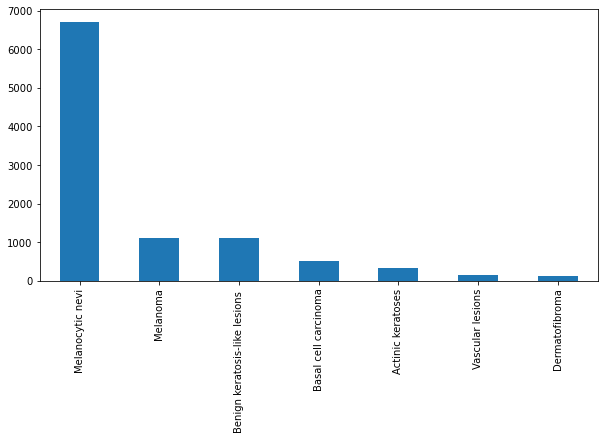

In [33]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
df_skin['cell_type'].value_counts().plot(kind='bar', ax=ax1)

Its seems from the above plot that in this dataset cell type Melanecytic nevi has very large number of instances in comparison to other cell types

<AxesSubplot:>

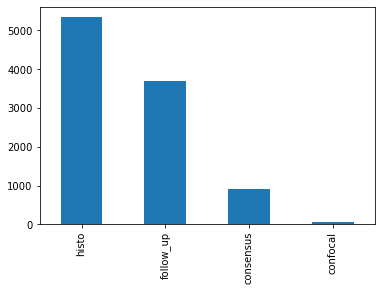

In [19]:
df_skin['dx_type'].value_counts().plot(kind='bar')

Plotting the distribution of localization field

<AxesSubplot:>

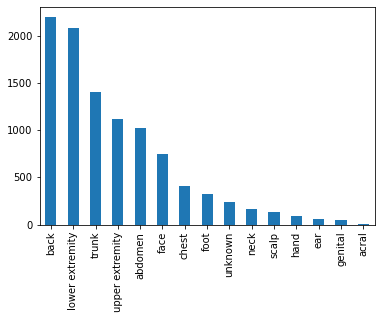

In [20]:
df_skin['localization'].value_counts().plot(kind='bar')

It seems back , lower extremity,trunk and upper extremity are heavily compromised regions of skin cancer

<AxesSubplot:>

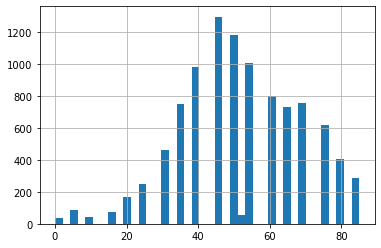

In [21]:
df_skin['age'].hist(bins=40)

It seems that there are larger instances of patients having age from 30 to 60

Lets see the distribution of males and females

<AxesSubplot:>

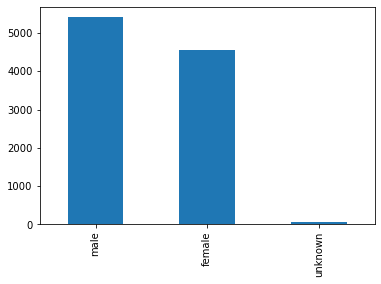

In [22]:
df_skin['sex'].value_counts().plot(kind='bar')

In [23]:
print('The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels')

# Display the count of each lesion.
df_skin['lesion_type'].value_counts()

The problem is unbalanced, since Melanocytic nevi is much more frequent that other labels


Melanocytic nevi                  6705
Melanoma                          1113
Benign keratosis-like lesions     1099
Basal cell carcinoma               514
Actinic keratoses                  327
Vascular lesions                   142
Dermatofibroma                     115
Name: lesion_type, dtype: int64

C:\Users\spoor_ihd9451\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='age', ylabel='lesion_type'>

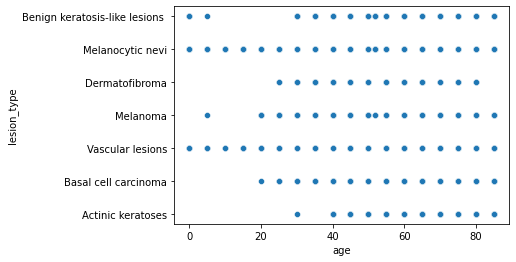

In [26]:
sns.scatterplot('age','lesion_type',data=df_skin)

It seems that skin cancer types 0,1, 3 and 5 which are Melanocytic nevi,dermatofibroma,Basal cell carcinoma and Vascular lesions are not much prevalant below the age of 20 years

Sex wise distribution of skin cancer type

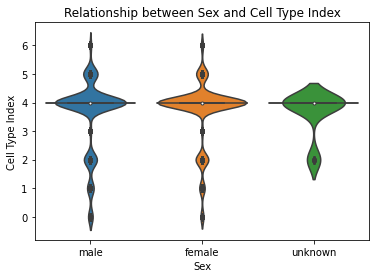

In [34]:
# Create a box plot or violin plot
sns.boxplot(x='sex', y='cell_type_idx', data=df_skin)
sns.violinplot(x='sex', y='cell_type_idx', data=df_skin)
plt.xlabel('Sex')
plt.ylabel('Cell Type Index')
plt.title('Relationship between Sex and Cell Type Index')
plt.show()

### Loading and resizing of images

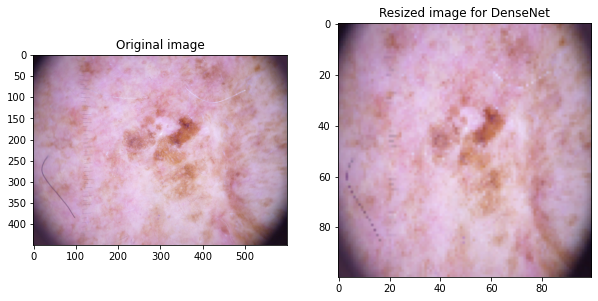

In [55]:
# Reading a random image from our data set
fname_images = np.array(df_skin['image_id'])
file_to_read ='/Users/spoor_ihd9451/Desktop/AI/input/HAM10000_images_part_1/'+str(fname_images[1])+'.jpg'

# Resizing the read image to 100x100
img = imread(file_to_read)
img2 = resize(img, (100, 100))

# Show one exampe image before and after
plt.figure(figsize = (10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img[:, :, ::-1])
plt.title('Original image')
plt.subplot(1, 2, 2)
plt.imshow(img2[:, :, ::-1])
plt.title('Resized image for DenseNet')
plt.show()

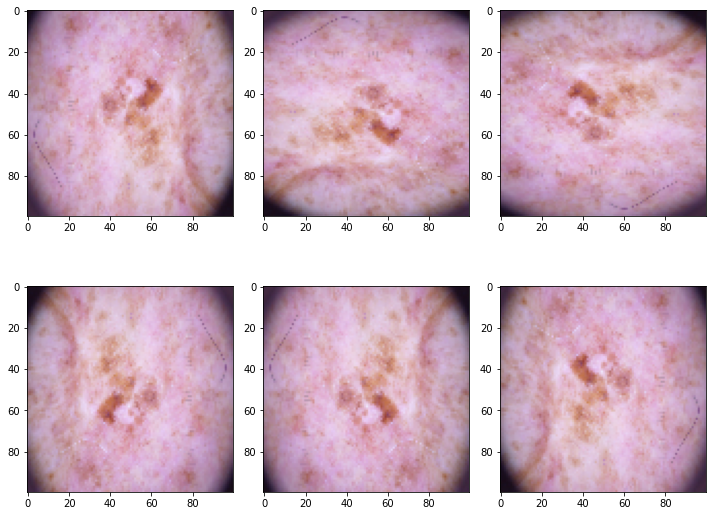

In [56]:
def produce_new_img(img2: cv2) -> tuple:
    """
    function to reproduse a new manipulated (rotating of flipping the original one)
    image from the read one, To increase the dimension of the dataset, avoiding overfitting of a single class.

    Args:
        img2 (cv2): the read image from cv2 module.

    Returns:
        new_images (tuple): a tuple of the new manipulated images.
    """
    imga = cv2.rotate(img2, cv2.ROTATE_90_CLOCKWISE)
    imgb = cv2.rotate(img2, cv2.ROTATE_90_COUNTERCLOCKWISE)
    imgc = cv2.rotate(img2, cv2.ROTATE_180)
    imgd = cv2.flip(img2, 0)
    imge = cv2.flip(img2, 1)
    new_imges = imga, imgb, imgc, imgd ,imge
    return new_imges

def show_example() -> None:
    """
    Display an image after manipulating it in produce_new_img() function
    """
    plt.figure(figsize = (10, 8))
    plt.subplot(2, 3, 1)
    plt.imshow(img2[:, :, ::-1])
    for i in range(5):
        plt.subplot(2, 3, 2+i)
        plt.imshow(new_img[i][:, :, ::-1])
    plt.tight_layout()
    plt.show()

# Invoking our function :)
new_img = produce_new_img(img2)
# Display an example by invoking show_example func
show_example()

In [57]:
x = []          # Hold resized images.
y = []          # Hold image lesion ID from the data set.

# Listing all files in the part_1, part_2 dirs
lista1 = os.listdir('/Users/spoor_ihd9451/Desktop/AI/input/HAM10000_images_part_1/')
lista2 = os.listdir('/Users/spoor_ihd9451/Desktop/AI/input/HAM10000_images_part_2/')

# [+] Handling images from part 1 directory
for i in range(len(lista1)):
    # [+] Features: reading and resize the photo.
    fname_image = lista1[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/Users/spoor_ihd9451/Desktop/AI/input/HAM10000_images_part_1/' + str(fname_image)  # resolve image name
    img = imread(file_to_read)                                  # read the image 
    img2 = resize(img,(100, 100))                               # resise our image
    x.append(img2)                                              # append the new image to the list x.
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # add more images for class between 1-6, rotating them 
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])

    # inform the user with the number of loaded images each 100 img.
    if i % 100 == 0:
        print(i, 'images loaded')


# [+] Handling images from part 2 directory
for i in range(len(lista2)):

    # [+] Features: reading and resize the photo.
    fname_image = lista2[i]
    fname_ID = fname_image.replace('.jpg', '')
    file_to_read ='/Users/spoor_ihd9451/Desktop/AI/input/HAM10000_images_part_2/' + str(fname_image)


    img = imread(file_to_read)
    img2 = resize(img, (100, 100))
    x.append(img2)
    
    # Targets: Finding the image lesion ID and append it to the y list.
    output = np.array(df_skin[df_skin['image_id'] == fname_ID].lesion_ID)
    y.append(output[0])
    
    # [+] Add more images for class between 1-6
    if output != 0:
        new_img = produce_new_img(img2)
        for i in range(5):
            x.append(new_img[i])
            y.append(output[0])
    
    if i % 100 == 0: # [+] Inform the user with the number of loaded images each 100 img.
        print(len(lista1) + i,'images loaded')

0 images loaded
100 images loaded
200 images loaded
300 images loaded
600 images loaded
700 images loaded
800 images loaded
900 images loaded
1000 images loaded
1100 images loaded
1200 images loaded
1400 images loaded
1500 images loaded
1700 images loaded
1800 images loaded
2000 images loaded
2100 images loaded
2400 images loaded
2500 images loaded
2600 images loaded
2800 images loaded
2900 images loaded
3100 images loaded
3600 images loaded
3700 images loaded
3900 images loaded
4200 images loaded
4300 images loaded
4400 images loaded
4500 images loaded
4600 images loaded
4700 images loaded
4800 images loaded
5000 images loaded
5200 images loaded
5400 images loaded
5500 images loaded
5600 images loaded
5700 images loaded
5900 images loaded
6000 images loaded
6100 images loaded
6200 images loaded
6600 images loaded
6700 images loaded
6800 images loaded
6900 images loaded
7000 images loaded
7300 images loaded
7500 images loaded
7600 images loaded
7800 images loaded
8100 images loaded
820

### Train Test Split

In [58]:
x = np.array(x)
y = np.array(y)

# convert y (targets) array as required by softmax activation function
y_train = to_categorical(y, num_classes = 7)

In [59]:
# split in 80% training and 20% test data
X_train, X_test, y_train, y_test = train_test_split(x,                  # Images array.
                                                    y_train,            # The training set.
                                                    test_size = 0.20,   # Split data set into 20/80.
                                                    random_state = 50,  # Shuffling number to random the set.
                                                    stratify = y)       # Mix training and test sets.
# [+] Display the count of train/test data set.
print('Train dataset shape', X_train.shape)
print('Test dataset shape', X_test.shape)

Train dataset shape (21252, 100, 100, 3)
Test dataset shape (5313, 100, 100, 3)


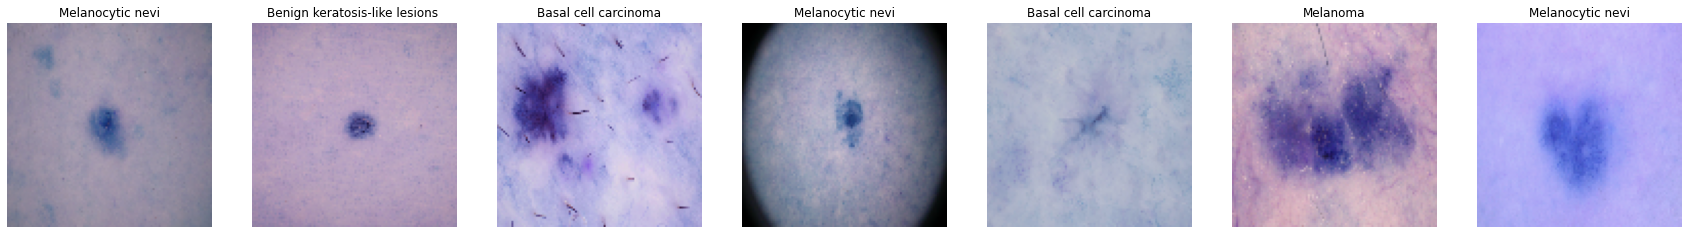

In [60]:
def show_neg_figuers() -> None:
    """ Display negative figuers of the classes. """
    # Figure, Axes
    _, ax = plt.subplots(1, 7, figsize = (30, 30))
    for i in range(7):
        ax[i].set_axis_off()                                    # set the image to negative.
        ax[i].imshow(X_train[i])                                # Display the img.
        ax[i].set_title(lesion_names[np.argmax(y_train[i])])    # Set image title.

show_neg_figuers()

In [61]:
def est_class_weights(dis_id: np.array) -> dict:
    """Estimate class weights for unbalanced datasets.

    Args:
        dis_id (np.array): numpy array of dis IDs

    Returns:
        dict: Estimated class weights for for unbalanced datasets.
    """
    class_weights = np.around(compute_class_weight(class_weight = 'balanced', classes = np.unique(dis_id), y = y), 2)
    class_weights = dict(zip(np.unique(dis_id), class_weights))

y_id = np.array(df_skin['lesion_ID'])
new_class_weights = est_class_weights(y_id)
print('The problem is unbalanced. We need to provide class-weights')
print(new_class_weights)

The problem is unbalanced. We need to provide class-weights
None


### Building Model and Chceking accuracy 

In [62]:
model = Sequential()
        
# [+] 1st convolutional layer
model.add(Conv2D(filters = 96,
                kernel_size = (11, 11),
                strides = (4, 4),
                activation = 'relu',
                input_shape = (100, 100, 3)))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 2nd convolutional layer
model.add(Conv2D(filters = 256,
                kernel_size=(5, 5),
                strides=(1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))

# [+] 3rd convolutional layer
model.add(Conv2D(filters = 384,
                 kernel_size=(3,3),
                 strides=(1,1),
                 activation='relu',
                 padding="same"))
model.add(BatchNormalization())

# [+] 4th convolutional layer
model.add(Conv2D(filters = 384,
                kernel_size = (1, 1), 
                strides = (1, 1), 
                activation = 'relu', 
                padding = "same"))
model.add(BatchNormalization())

# [+] 5th convolutional layer
model.add(Conv2D(filters = 256, 
                kernel_size = (1, 1),
                strides = (1, 1),
                activation = 'relu',
                padding = "same"))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (3, 3), strides = (2, 2)))
              
model.add(Flatten())  # [+] Convert the Conv2D objects into one List.

# [+] 6th, Dense layer:
# From the Docs: 
# A Dense layer feeds all outputs from the previous layer to all its neurons,
# each neuron providing one output to the next layer.
# source: www.stackoverflow.com
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 7th Dense layer
model.add(Dense(4096, activation = 'relu'))
model.add(Dropout(0.5))
              
# [+] 8th output layer
model.add(Dense(7, activation = 'softmax'))

In [63]:
def mod_checkpoint_callback() -> None:
    """
    Saving our model
    
    Returns:
        None: Saving a checkpoint of the model.
    """
    trained_model = ModelCheckpoint(filepath = 'model.h5',  # result file name
                             save_weights_only = False,     # Save all training results/params.
                             monitor = 'val_accuracy',      # check our model accuracy if it's step forward.
                             mode = 'auto',                 # enable auto save.
                             save_best_only = True,         # if ac_new > ac_old
                             verbose = 1)
    return trained_model

# Montoring the training procces in each epoch.
early_stopping_monitor = EarlyStopping(patience = 100, monitor = 'val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()

# Estimate the model data if it was big one.
optimizer = Adam(lr = 0.0001, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-3)
model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

datagen = ImageDataGenerator(zoom_range = 0.2, horizontal_flip = True, shear_range = 0.2)
datagen.fit(X_train)

batch_size = 32     # samples in the network at once.
epochs = 100        # epochs number.

# org model result data
history = model.fit(datagen.flow(X_train,y_train),
                    epochs = epochs,
                    batch_size = batch_size,
                    shuffle = True,
                    callbacks = [early_stopping_monitor, model_checkpoint_callback],
                    validation_data = (X_test, y_test),
                    class_weight = new_class_weights
                )

Epoch 1/100
665/665 [==============================] - ETA: 0s - loss: 1.5316 - accuracy: 0.4704
Epoch 1: val_accuracy improved from -inf to 0.34161, saving model to model.h5
665/665 [==============================] - 802s 854ms/step - loss: 1.5316 - accuracy: 0.4704 - val_loss: 2.0687 - val_accuracy: 0.3416
Epoch 2/100
665/665 [==============================] - ETA: 0s - loss: 1.1901 - accuracy: 0.5477
Epoch 2: val_accuracy improved from 0.34161 to 0.45624, saving model to model.h5
665/665 [==============================] - 559s 838ms/step - loss: 1.1901 - accuracy: 0.5477 - val_loss: 1.5687 - val_accuracy: 0.4562
Epoch 3/100
665/665 [==============================] - ETA: 0s - loss: 1.1004 - accuracy: 0.5792
Epoch 3: val_accuracy did not improve from 0.45624
665/665 [==============================] - 703s 1s/step - loss: 1.1004 - accuracy: 0.5792 - val_loss: 1.5071 - val_accuracy: 0.4209
Epoch 4/100
665/665 [==============================] - ETA: 0s - loss: 1.0468 - accuracy: 0.5989


In [64]:
scores = model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 18s 105ms/step - loss: 0.4760 - accuracy: 0.8566
Accuracy: 85.66%


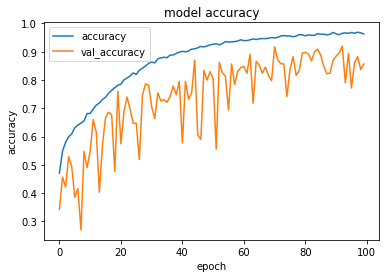

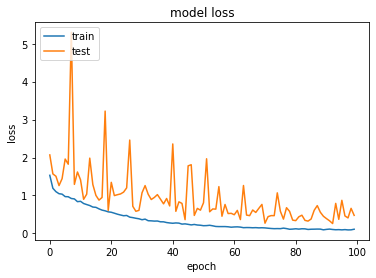

In [66]:
def display_accuracy() -> None:
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['accuracy', 'val_accuracy'], loc='upper left')
    plt.show()

def display_loss() -> None:
    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

display_accuracy()
display_loss()

In [67]:
y_pred = model.predict(X_test)

def test_model() -> tuple:
    """ Tunning the accurate results and inaccurate results

    Returns:
        (total, accurate) [tuple]: tuple of total tested test-cases, accurate
    """
    total = 0
    accurate = 0
    accurateindex = []
    wrongindex = []
    for i in range(len(y_pred)):
        if np.argmax(y_pred[i]) == np.argmax(y_test[i]):
            accurate += 1
            accurateindex.append(i)
        else:
            wrongindex.append(i)
        total += 1
    return (total, accurate)

total, accurate = test_model()
print('Total-test-data;', total, '\taccurately-predicted-data:', accurate, '\t wrongly-predicted-data: ', total - accurate)
print('Accuracy:', round(accurate / total * 100, 3), '%')

167/167 [==============================] - 38s 100ms/step
Total-test-data; 5313 	accurately-predicted-data: 4551 	 wrongly-predicted-data:  762
Accuracy: 85.658 %


In [68]:
best_model = load_model('./model.h5')

# Compute predictions
y_pred_prob = np.around(best_model.predict(X_test),3)
y_pred = np.argmax(y_pred_prob, axis = 1)
y_test2 = np.argmax(y_test, axis = 1)

167/167 [==============================] - 18s 101ms/step


In [69]:
scores = best_model.evaluate(X_test, y_test, verbose = 1)
print("Accuracy: %.2f%%" % (scores[1] * 100))

167/167 [==============================] - 19s 101ms/step - loss: 0.2598 - accuracy: 0.9198
Accuracy: 91.98%


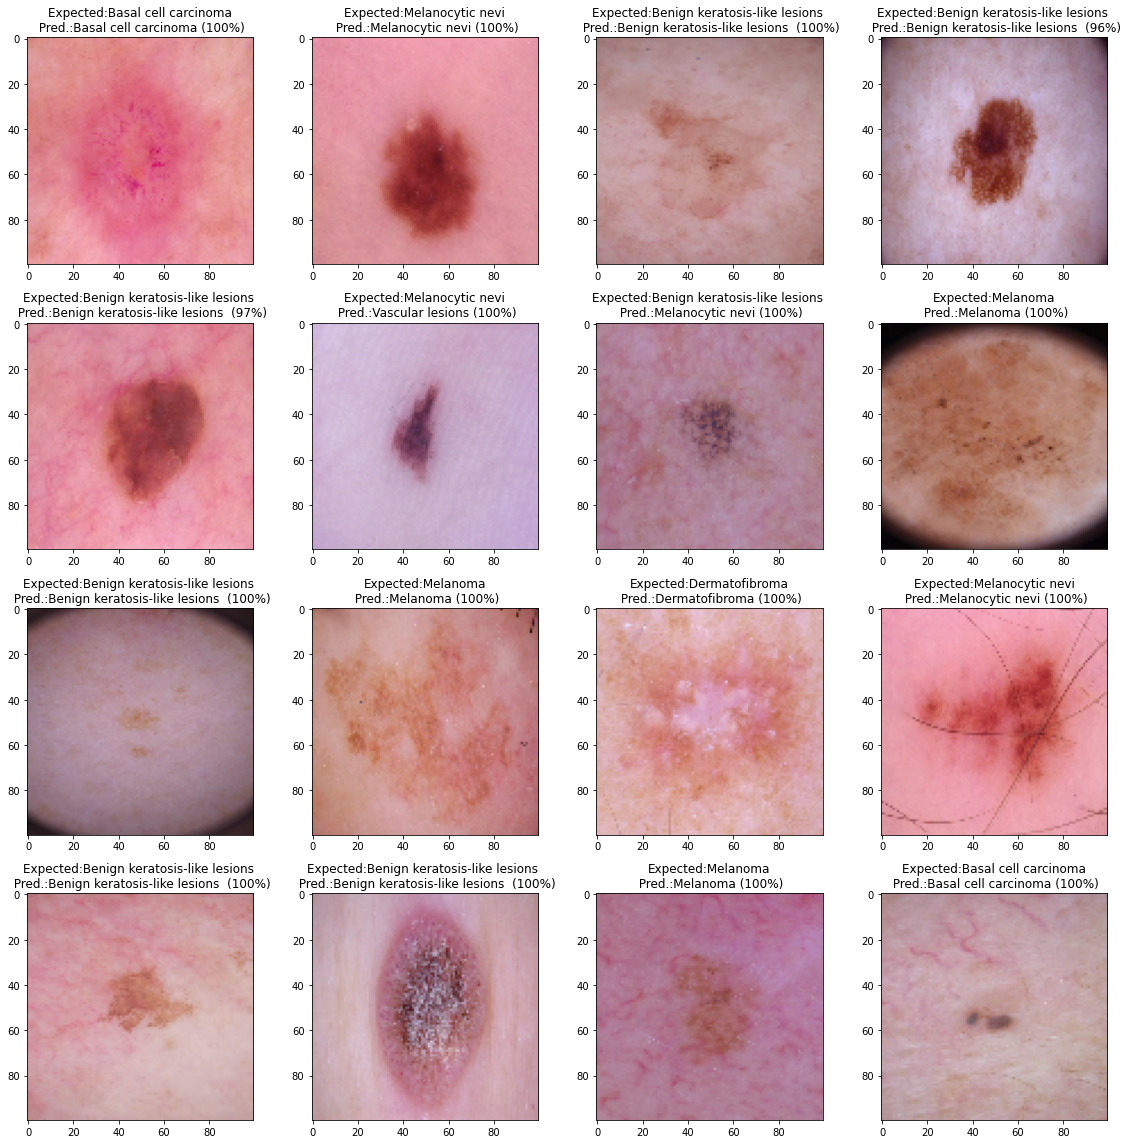

In [70]:
plt.figure(figsize=(16,16))
for i in range(16):
    plt.subplot(4,4,i+1)
    index = i+100
    plt.imshow(X_test[index,:,:,::-1])
    label_exp = lesion_names[y_test2[index]]  #expected label
    label_pred = lesion_names[y_pred[index]]  #predicted label
    label_pred_prob = round(np.max(y_pred_prob[index])*100)
    plt.title('Expected:'+str(label_exp)+'\n Pred.:'+str(label_pred)+' ('+str(label_pred_prob)+'%)')
plt.ylabel('')
plt.tight_layout()
plt.savefig('final_figure.png',dpi=300)
plt.show()

In [71]:
#Accuracy for each type
acc_tot= []

for i in range(7):
    acc_parz = round(np.mean(y_test2[y_test2 == i] == y_pred[y_test2 == i]),2)
    lab_parz = lesion_names[i]
    print('accuracy for',lab_parz,'=',acc_parz)
    acc_tot.append(acc_parz)

accuracy for Melanocytic nevi = 0.87
accuracy for Melanoma = 0.92
accuracy for Benign keratosis-like lesions  = 0.92
accuracy for Basal cell carcinoma = 0.98
accuracy for Actinic keratoses = 0.95
accuracy for Vascular lesions = 0.99
accuracy for Dermatofibroma = 0.93


In [72]:
acc_tot = np.array(acc_tot)
freq = np.unique(y_test2,return_counts=True)[1]

np.sum(acc_tot*freq)/np.sum(freq)

0.9190607942781857